In [6]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('Superstore.csv', index_col = 0, encoding ='latin1')
print(df.head())

In [24]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [7]:
# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Preview the dataset
print(df[['Order Date', 'Sales']].head())

In [26]:
# Filter for years 2014 to 2017
df = df[(df['Order Date'] >= '2014-01-01') & (df['Order Date'] <= '2017-12-31')]


In [8]:
# Set order date as index
df.set_index('Order Date', inplace=True)

# Resample monthly average sales
monthly_avg_sales = df['Sales'].resample('ME').mean()
print(monthly_avg_sales.head())


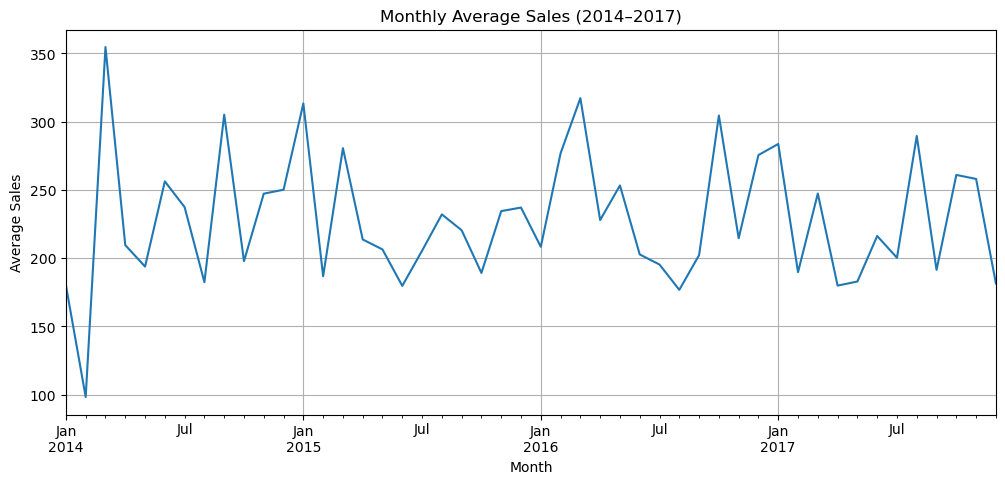

In [28]:
import matplotlib.pyplot as plt

monthly_avg_sales.plot(figsize=(12, 5), title='Monthly Average Sales (2014–2017)')
plt.ylabel("Average Sales")
plt.xlabel("Month")
plt.grid(True)
plt.show()


In [ ]:
# Prepare full dataset
!pip install prophet
df_prophet = monthly_avg_sales.reset_index()
df_prophet.columns = ['ds', 'y']

# Split: train = 2014–2016, test = 2017
train = df_prophet[df_prophet['ds'] < '2017-01-01']
test = df_prophet[df_prophet['ds'] >= '2017-01-01']


In [12]:
from prophet import Prophet

model = Prophet(yearly_seasonality=True)
model.fit(train)

# Create future dates (length = len(test))
future = model.make_future_dataframe(periods=len(test), freq='ME')
forecast = model.predict(future)


22:52:13 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# Extract forecasted values for test period
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

# Join actual and predicted
comparison = test.copy()
comparison['yhat'] = forecast_test['yhat'].values

print(comparison[['ds', 'y', 'yhat']])


           ds           y        yhat
36 2017-01-31  283.686284  158.587934
37 2017-02-28  189.730219  204.647144
38 2017-03-31  247.362827  314.639390
39 2017-04-30  179.909045  214.268953
40 2017-05-31  182.897150  224.918523
41 2017-06-30  216.251942  211.995075
42 2017-07-31  200.285027  208.073026
43 2017-08-31  289.545358  186.728271
44 2017-09-30  191.430614  235.306440
45 2017-10-31  260.996387  257.133555
46 2017-11-30  258.056264  224.053178
47 2017-12-31  181.448742  257.917891


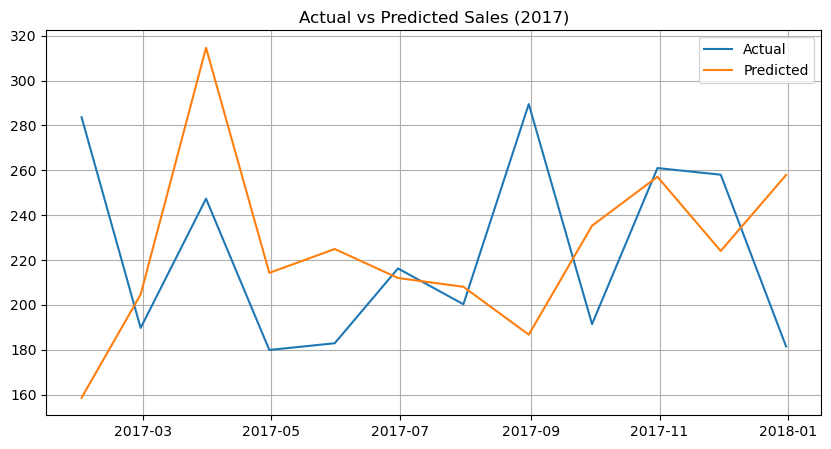

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(comparison['ds'], comparison['y'], label='Actual')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted')
plt.title("Actual vs Predicted Sales (2017)")
plt.legend()
plt.grid(True)
plt.show()


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 46.40
RMSE: 59.82


In [ ]:

# Reset index to ensure datetime index
!pip install statsmodels
monthly_avg_sales = monthly_avg_sales.asfreq('ME')  # Make sure it's monthly frequency

# Train: 2014-2016, Test: 2017

train = monthly_avg_sales[:'2016-12']
test = monthly_avg_sales['2017-01':]

In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build model: (1,1,1) with seasonal (1,1,1,12)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)


In [51]:
# Forecast same number of periods as test
n_periods = len(test)
forecast = model_fit.forecast(steps=n_periods)

# Create DataFrame for comparison
sarima_result = pd.DataFrame({
    'ds': test.index,
    'actual': test.values,
    'predicted': forecast
})


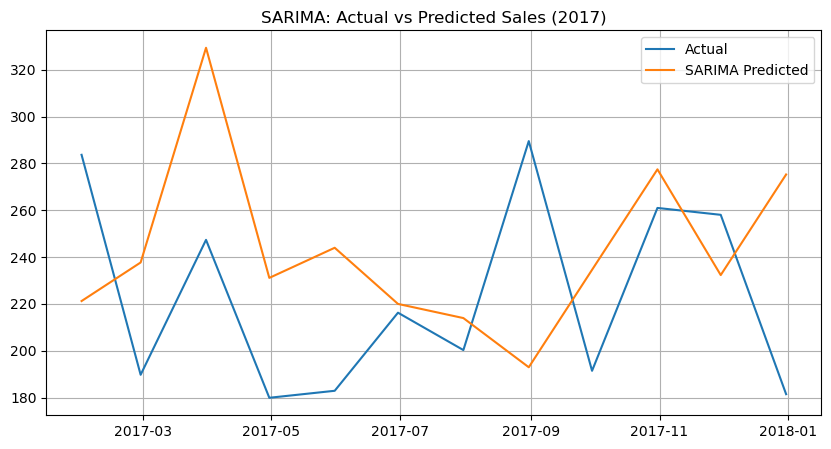

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(sarima_result['ds'], sarima_result['actual'], label='Actual')
plt.plot(sarima_result['ds'], sarima_result['predicted'], label='SARIMA Predicted')
plt.title("SARIMA: Actual vs Predicted Sales (2017)")
plt.legend()
plt.grid(True)
plt.show()


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(sarima_result['actual'], sarima_result['predicted'])
rmse = np.sqrt(mean_squared_error(sarima_result['actual'], sarima_result['predicted']))

print(f"SARIMA MAE: {mae:.2f}")
print(f"SARIMA RMSE: {rmse:.2f}")


SARIMA MAE: 49.83
SARIMA RMSE: 58.04


In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Full training data till 2017
full_train = monthly_avg_sales[:'2017-12']

# Re-train SARIMA model
model_full = SARIMAX(full_train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_full_fit = model_full.fit(disp=False)


C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [57]:
# Forecast for Jan 2018 to Dec 2018 (12 steps)
forecast_2018 = model_full_fit.forecast(steps=12)

# Create datetime index for 2018
forecast_index = pd.date_range(start='2018-01-01', periods=12, freq='MS')  # MS = month start

# Create final DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Predicted_Sales': forecast_2018
})
forecast_df.set_index('Date', inplace=True)


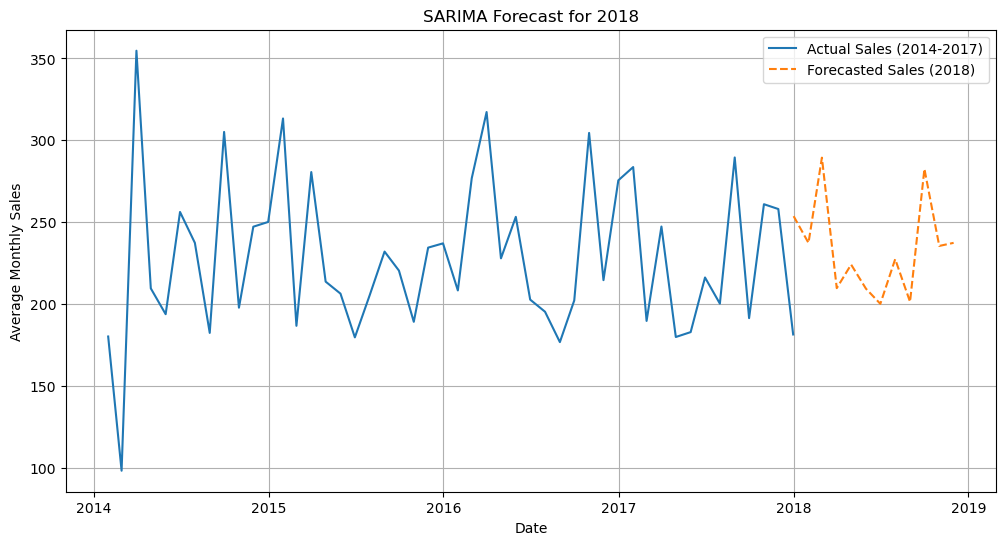

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly_avg_sales, label='Actual Sales (2014-2017)')
plt.plot(forecast_df, label='Forecasted Sales (2018)', linestyle='--')
plt.title('SARIMA Forecast for 2018')
plt.xlabel('Date')
plt.ylabel('Average Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
forecast_df.to_excel('forecast_2018_sales.xlsx', index=False)

